In [1]:
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

In [2]:
ROOT = Path(".")
DATA_DIR = ROOT / "data"
REAL_DIR = DATA_DIR / "real"
GEN_DIR  = DATA_DIR / "generated"
OUT_DIR  = ROOT / "outputs" / "step0"
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
def list_images(folder: Path, exts=(".png", ".jpg", ".jpeg", ".webp", ".tif", ".tiff", ".bmp")):
    files = []
    for ext in exts:
        files.extend(folder.rglob(f"*{ext}"))
        files.extend(folder.rglob(f"*{ext.upper()}"))
    return sorted(set(files))

real_paths = list_images(REAL_DIR)
gen_paths  = list_images(GEN_DIR)

print(f"Found real: {len(real_paths)} | generated: {len(gen_paths)}")
assert len(real_paths) > 0 and len(gen_paths) > 0, "No images found. Check folder names and extensions."

real_paths[:3], gen_paths[:3]

Found real: 65 | generated: 65


([WindowsPath('data/real/images/10pm_feeding_around_the_clock.webp'),
  WindowsPath('data/real/images/11pm.webp'),
  WindowsPath('data/real/images/12_4_7_10.webp')],
 [WindowsPath('data/generated/ComfyUI_00082_.png'),
  WindowsPath('data/generated/ComfyUI_00083_.png'),
  WindowsPath('data/generated/ComfyUI_00084_.png')])

### Standardization of images

In [4]:
def read_image_bgr(path: Path) -> np.ndarray:
    """
    Reads image as BGR (OpenCV default). Preserves native resolution.
    """
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Failed to read image: {path}")
    return img

In [5]:
def to_grayscale(img_bgr: np.ndarray) -> np.ndarray:
    """
    Convert BGR -> 8-bit grayscale.
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    return gray

In [6]:
def compute_scale_terms(gray: np.ndarray) -> dict:
    """
    Compute scale terms used for relative parameters in later steps.
    """
    H, W = gray.shape[:2]
    L = float(max(H, W))              # long side
    D = float(np.hypot(H, W))         # diagonal
    return {"H": H, "W": W, "L": L, "D": D}

In [7]:
def safe_imwrite(path: Path, img: np.ndarray) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    ok = cv2.imwrite(str(path), img)
    if not ok:
        raise ValueError(f"Failed to write image: {path}")

In [8]:
CACHE_GRAYS = True

records = []

def process_one(path: Path, split: str):
    img_bgr = read_image_bgr(path)
    gray = to_grayscale(img_bgr)
    scales = compute_scale_terms(gray)

    rec = {
        "split": split,                      # "real" or "generated"
        "filename": path.name,
        "rel_path": str(path.as_posix()),
        **scales,
    }

    if CACHE_GRAYS:
        # Mirror folder structure under outputs/step0/grayscale/{split}/...
        out_gray = OUT_DIR / "grayscale" / split / path.name
        safe_imwrite(out_gray, gray)
        rec["gray_path"] = str(out_gray.as_posix())
    else:
        rec["gray_path"] = ""

    return rec

In [9]:
for p in real_paths:
    records.append(process_one(p, "real"))

for p in gen_paths:
    records.append(process_one(p, "generated"))

df0 = pd.DataFrame(records)

# Save index
csv_path = OUT_DIR / "index_step0.csv"
df0.to_csv(csv_path, index=False)

df0.head(), csv_path

(  split                            filename  \
 0  real  10pm_feeding_around_the_clock.webp   
 1  real                           11pm.webp   
 2  real                      12_4_7_10.webp   
 3  real               around_the_clock.webp   
 4  real      around_the_clock_alizarin.webp   
 
                                             rel_path    H     W       L  \
 0  data/real/images/10pm_feeding_around_the_clock...  749   750   750.0   
 1                         data/real/images/11pm.webp  642   500   642.0   
 2                    data/real/images/12_4_7_10.webp  749   750   750.0   
 3             data/real/images/around_the_clock.webp  799   750   799.0   
 4    data/real/images/around_the_clock_alizarin.webp  704  1000  1000.0   
 
              D                                          gray_path  
 0  1059.953301  outputs/step0/grayscale/real/10pm_feeding_arou...  
 1   813.734600             outputs/step0/grayscale/real/11pm.webp  
 2  1059.953301        outputs/step0/grayscal

Counts by split:


split
real         65
generated    65
Name: count, dtype: int64


Resolution summary (H, W):


H                                                         W  \
          count    mean     std    min    25%    50%    75%     max count   
split                                                                       
generated  65.0  512.00    0.00  512.0  512.0  512.0  512.0   512.0  65.0   
real       65.0  801.42  443.64  561.0  639.0  649.0  749.0  3000.0  65.0   

                   ...      L             D                                   \
             mean  ...    75%     max count     mean     std     min     25%   
split              ...                                                         
generated  512.00  ...  512.0   512.0  65.0   724.08    0.00  724.08  724.08   
real       723.58  ...  799.0  3000.0  65.0  1084.73  566.97  751.48  813.73   

                                     
              50%      75%      max  
split                                
generated  724.08   724.08   724.08  
real       942.02  1061.37  3891.31  

[2 rows x 32 columns]

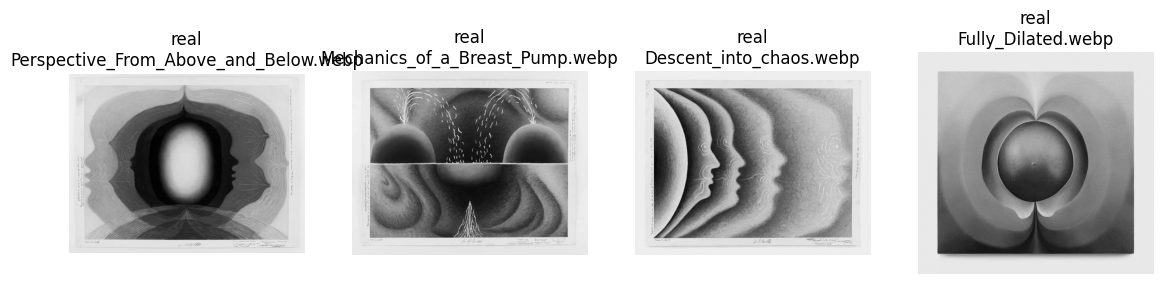

In [10]:
# Quick sanity checks

print("Counts by split:")
display(df0["split"].value_counts())

print("\nResolution summary (H, W):")
display(df0.groupby("split")[["H", "W", "L", "D"]].describe().round(2))

# Show a couple sample grays
import matplotlib.pyplot as plt

sample = df0.sample(4, random_state=42)
fig, ax = plt.subplots(1, 4, figsize=(14, 4))
for i, (_, row) in enumerate(sample.iterrows()):
    if row["gray_path"]:
        g = cv2.imread(row["gray_path"], cv2.IMREAD_GRAYSCALE)
    else:
        g = to_grayscale(read_image_bgr(Path(row["rel_path"])))
    ax[i].imshow(g, cmap="gray")
    ax[i].set_title(f'{row["split"]}\n{row["filename"]}')
    ax[i].axis("off")
plt.show()


### Shape Evidence Map

In [11]:
ROOT = Path(".")
OUT0 = ROOT / "outputs" / "step0"
OUT1 = ROOT / "outputs" / "step1"
OUT1.mkdir(parents=True, exist_ok=True)

df0 = pd.read_csv(OUT0 / "index_step0.csv")
df0.head()

,split,filename,rel_path,H,W,L,D,gray_path
0,real,10pm_feeding_around_the_clock.webp,data/real/images/10pm_feeding_around_the_clock...,749,750,750.0,1059.953301,outputs/step0/grayscale/real/10pm_feeding_arou...
1,real,11pm.webp,data/real/images/11pm.webp,642,500,642.0,813.734600,outputs/step0/grayscale/real/11pm.webp
2,real,12_4_7_10.webp,data/real/images/12_4_7_10.webp,749,750,750.0,1059.953301,outputs/step0/grayscale/real/12_4_7_10.webp
3,real,around_the_clock.webp,data/real/images/around_the_clock.webp,799,750,799.0,1095.856286,outputs/step0/grayscale/real/around_the_clock....
4,real,around_the_clock_alizarin.webp,data/real/images/around_the_clock_alizarin.webp,704,1000,1000.0,1222.953801,outputs/step0/grayscale/real/around_the_clock_...


#### Edge Helpers

In [12]:
# Edge helpers
KEEP_FRAC = 0.11

def to_float01(gray_u8: np.ndarray) -> np.ndarray:
    return gray_u8.astype(np.float32) / 255.0

def sobel_magnitude(gray_f01: np.ndarray, sigma: float) -> np.ndarray:
    if sigma > 0:
        k = int(round(sigma * 6))
        k = max(3, k)
        if k % 2 == 0:
            k += 1
        sm = cv2.GaussianBlur(gray_f01, (k, k), sigmaX=sigma, sigmaY=sigma)
    else:
        sm = gray_f01
    gx = cv2.Sobel(sm, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(sm, cv2.CV_32F, 0, 1, ksize=3)
    return cv2.magnitude(gx, gy)

def normalize_robust(x: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    lo = np.percentile(x, 1)
    hi = np.percentile(x, 99)
    x = (x - lo) / (hi - lo + eps)
    return np.clip(x, 0.0, 1.0)

def multi_scale_edge(gray_u8: np.ndarray, L: float,
                     rel_sigmas=(0.001, 0.002, 0.004),
                     combine="max") -> np.ndarray:
    gray_f = to_float01(gray_u8)
    mags = []
    for r in rel_sigmas:
        sigma = float(r) * float(L)
        m = sobel_magnitude(gray_f, sigma=sigma)
        mags.append(normalize_robust(m))
    if combine == "max":
        return np.maximum.reduce(mags)
    elif combine == "mean":
        return np.mean(mags, axis=0)
    else:
        raise ValueError("combine must be 'max' or 'mean'")

def binarize_edge(E_soft: np.ndarray, keep_frac: float = 0.11, eps: float = 1e-6) -> np.ndarray:
    vals = E_soft[E_soft > eps]
    if vals.size == 0:
        return np.zeros_like(E_soft, dtype=np.uint8)

    q = 100.0 * (1.0 - keep_frac)          # e.g., keep 3% => threshold at 97th percentile
    t = np.percentile(vals, q)
    return (E_soft >= t).astype(np.uint8)

#### Cleaning Helpers

In [13]:
def remove_small_components(binary_u8: np.ndarray, min_area_px: int) -> np.ndarray:
    binary_u8 = (binary_u8 > 0).astype(np.uint8)
    if binary_u8.max() == 0:
        return binary_u8

    num, labels, stats, _ = cv2.connectedComponentsWithStats(binary_u8, connectivity=8)

    out = np.zeros_like(binary_u8, dtype=np.uint8)
    # components are 1..num-1 (0 is background of zeros)
    for lab in range(1, num):
        area = stats[lab, cv2.CC_STAT_AREA]
        if area >= min_area_px:
            out[labels == lab] = 1
    return out

def morph_close(binary_u8: np.ndarray, ksize: int) -> np.ndarray:
    ksize = int(ksize)
    ksize = max(3, ksize)
    if ksize % 2 == 0:
        ksize += 1
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
    return cv2.morphologyEx(binary_u8, cv2.MORPH_CLOSE, kernel, iterations=1)

def clean_edges(E_soft, H, W, L, keep_frac=0.11,
                min_comp_area_frac=0.00005, close_ksize_frac=0.005):

    E_bin = binarize_edge(E_soft, keep_frac=keep_frac)

    min_area_px = int(max(8, min_comp_area_frac * (H * W)))
    E_bin = remove_small_components(E_bin, min_area_px=min_area_px)

    close_ksize = int(max(3, close_ksize_frac * L))
    if close_ksize % 2 == 0:
        close_ksize += 1
    E_bin = morph_close(E_bin, ksize=close_ksize)

    E_bin = remove_small_components(E_bin, min_area_px=min_area_px)

    E_soft_clean = (E_soft * E_bin.astype(np.float32)).astype(np.float32)
    return E_bin, E_soft_clean, {"min_area_px": min_area_px, "close_ksize": close_ksize}

In [14]:
OUT_EDGES_SOFT = OUT1 / "E_soft"
OUT_EDGES_BIN  = OUT1 / "E_bin"
OUT_EDGES_SOFT.mkdir(parents=True, exist_ok=True)
OUT_EDGES_BIN.mkdir(parents=True, exist_ok=True)

REL_SIGMAS = (0.001, 0.002, 0.004)
COMBINE = "max"
MIN_COMP_AREA_FRAC = 0.00005
CLOSE_KSIZE_FRAC = 0.002

records = []

for _, row in df0.iterrows():
    split = row["split"]
    img_path = Path(row["rel_path"])
    gray_path = row["gray_path"] if isinstance(row["gray_path"], str) and row["gray_path"] else None

    if gray_path:
        gray = cv2.imread(gray_path, cv2.IMREAD_GRAYSCALE)
    else:
        bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    H, W = gray.shape[:2]
    L = float(max(H, W))

    E_soft = multi_scale_edge(gray, L=L, rel_sigmas=REL_SIGMAS, combine=COMBINE)
    E_bin, E_soft_clean, meta = clean_edges(
        E_soft, H=H, W=W, L=L,
        keep_frac=KEEP_FRAC,
        min_comp_area_frac=MIN_COMP_AREA_FRAC,
        close_ksize_frac=CLOSE_KSIZE_FRAC
    )

    out_soft = OUT_EDGES_SOFT / split / (img_path.stem + "_Esoft.png")
    out_bin  = OUT_EDGES_BIN  / split / (img_path.stem + "_Ebin.png")
    out_soft.parent.mkdir(parents=True, exist_ok=True)
    out_bin.parent.mkdir(parents=True, exist_ok=True)

    cv2.imwrite(str(out_soft), (E_soft_clean * 255.0).clip(0, 255).astype(np.uint8))
    cv2.imwrite(str(out_bin),  (E_bin * 255).astype(np.uint8))

    records.append({
        "split": split,
        "filename": row["filename"],
        "rel_path": str(img_path.as_posix()),
        "E_soft_path": str(out_soft.as_posix()),
        "E_bin_path": str(out_bin.as_posix()),
        "H": H, "W": W, "L": L,
        "sigmas_used": str([float(r)*L for r in REL_SIGMAS]),
        **meta,
        "min_comp_area_frac": MIN_COMP_AREA_FRAC,
        "close_ksize_frac": CLOSE_KSIZE_FRAC,
        "combine": COMBINE,
        "binarize": "top_percentile_keep"
    })

df1 = pd.DataFrame(records)
csv1 = OUT1 / "index_edges.csv"
df1.to_csv(csv1, index=False)

print("Saved:", csv1, "| rows:", len(df1))
df1.head()

Saved: outputs\step1\index_edges.csv | rows: 130


,split,filename,rel_path,E_soft_path,E_bin_path,H,W,L,sigmas_used,min_area_px,close_ksize,min_comp_area_frac,close_ksize_frac,combine,binarize
0,real,10pm_feeding_around_the_clock.webp,data/real/images/10pm_feeding_around_the_clock...,outputs/step1/E_soft/real/10pm_feeding_around_...,outputs/step1/E_bin/real/10pm_feeding_around_t...,749,750,750.0,"[0.75, 1.5, 3.0]",28,3,0.00005,0.002,max,top_percentile_keep
1,real,11pm.webp,data/real/images/11pm.webp,outputs/step1/E_soft/real/11pm_Esoft.png,outputs/step1/E_bin/real/11pm_Ebin.png,642,500,642.0,"[0.642, 1.284, 2.568]",16,3,0.00005,0.002,max,top_percentile_keep
2,real,12_4_7_10.webp,data/real/images/12_4_7_10.webp,outputs/step1/E_soft/real/12_4_7_10_Esoft.png,outputs/step1/E_bin/real/12_4_7_10_Ebin.png,749,750,750.0,"[0.75, 1.5, 3.0]",28,3,0.00005,0.002,max,top_percentile_keep
3,real,around_the_clock.webp,data/real/images/around_the_clock.webp,outputs/step1/E_soft/real/around_the_clock_Eso...,outputs/step1/E_bin/real/around_the_clock_Ebin...,799,750,799.0,"[0.799, 1.598, 3.196]",29,3,0.00005,0.002,max,top_percentile_keep
4,real,around_the_clock_alizarin.webp,data/real/images/around_the_clock_alizarin.webp,outputs/step1/E_soft/real/around_the_clock_ali...,outputs/step1/E_bin/real/around_the_clock_aliz...,704,1000,1000.0,"[1.0, 2.0, 4.0]",35,3,0.00005,0.002,max,top_percentile_keep


10pm_feeding_around_the_clock.webp min/max: 0 1 white%: 10.95113484646195


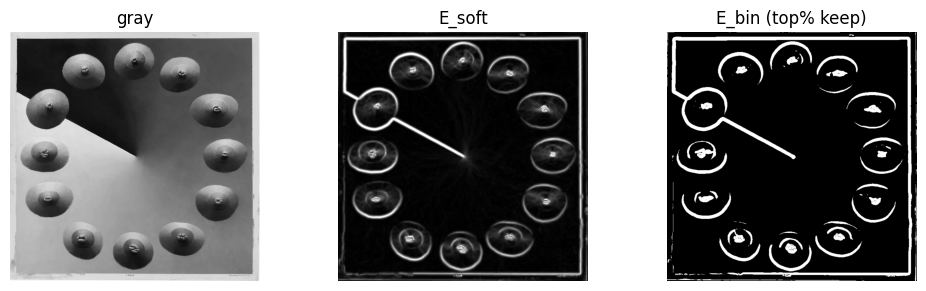

11pm.webp min/max: 0 1 white%: 10.265109034267912


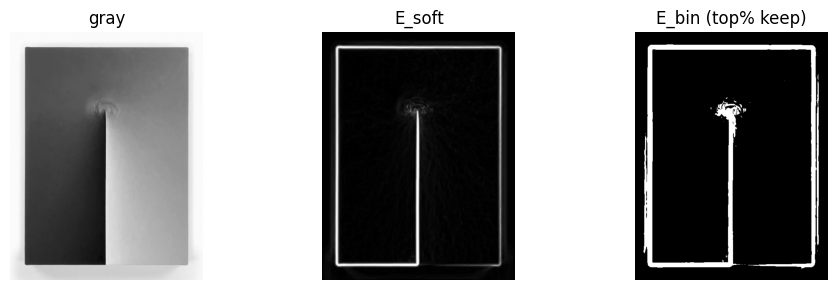

In [15]:
# Visual sanity check on a few images (soft + binary)
test_names = ["10pm_feeding_around_the_clock.webp", "11pm.webp"]

for name in test_names:
    row = df0[df0["filename"] == name].iloc[0]
    gray = cv2.imread(row["gray_path"], cv2.IMREAD_GRAYSCALE)
    H, W = gray.shape
    L = float(max(H, W))

    E_soft = multi_scale_edge(gray, L=L, rel_sigmas=REL_SIGMAS, combine=COMBINE)
    E_bin  = binarize_edge(E_soft, keep_frac=0.11)

    print(name, "min/max:", E_bin.min(), E_bin.max(), "white%:", (E_bin>0).mean()*100)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.imshow(gray, cmap="gray"); plt.title("gray"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(E_soft, cmap="gray"); plt.title("E_soft"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(E_bin, cmap="gray"); plt.title("E_bin (top% keep)"); plt.axis("off")
    plt.tight_layout(); plt.show()

In [16]:
df1 = pd.read_csv("outputs/step1/index_edges.csv")

# 1) Do files exist?
missing_soft = [p for p in df1["E_soft_path"].head(20) if not Path(p).exists()]
missing_bin  = [p for p in df1["E_bin_path"].head(20)  if not Path(p).exists()]

print("Missing soft (first 20):", len(missing_soft))
print("Missing bin  (first 20):", len(missing_bin))
if missing_soft: print("Example missing soft:", missing_soft[0])
if missing_bin:  print("Example missing bin :", missing_bin[0])

# 2) Are saved binaries sane? (edge density)
dens = []
for p in df1["E_bin_path"].head(20):
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if img is None:
        dens.append(np.nan)
    else:
        dens.append((img > 0).mean())

print("Edge density stats (first 20):")
print("min/mean/max =", np.nanmin(dens), np.nanmean(dens), np.nanmax(dens))

Missing soft (first 20): 0
Missing bin  (first 20): 0
Edge density stats (first 20):
min/mean/max = 0.06583869999224097 0.09968442413329277 0.11150262697022767


Ebin edge%: 11.145883400089007 min/max: 0 255


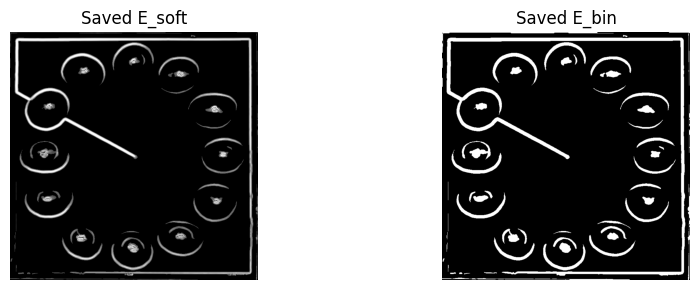

In [17]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd

df1 = pd.read_csv("outputs/step1/index_edges.csv")
row = df1[df1["filename"]=="10pm_feeding_around_the_clock.webp"].iloc[0]

Ebin = cv2.imread(row["E_bin_path"], cv2.IMREAD_GRAYSCALE)
Esoft = cv2.imread(row["E_soft_path"], cv2.IMREAD_GRAYSCALE)

print("Ebin edge%:", (Ebin>0).mean()*100, "min/max:", Ebin.min(), Ebin.max())

plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.imshow(Esoft, cmap="gray"); plt.title("Saved E_soft"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(Ebin, cmap="gray");  plt.title("Saved E_bin");  plt.axis("off")
plt.tight_layout(); plt.show()

### Fill Closed contour

In [18]:
ROOT = Path(".")
OUT0 = ROOT / "outputs" / "step0"
OUT1 = ROOT / "outputs" / "step1"
OUT2 = ROOT / "outputs" / "step2"
OUT2.mkdir(parents=True, exist_ok=True)

df0 = pd.read_csv(OUT0 / "index_step0.csv")
df1 = pd.read_csv(OUT1 / "index_edges.csv")

REGION_DIR = OUT2 / "regions"
DEBUG_DIR  = OUT2 / "debug"
if REGION_DIR.exists(): shutil.rmtree(REGION_DIR)
if DEBUG_DIR.exists():  shutil.rmtree(DEBUG_DIR)
REGION_DIR.mkdir(parents=True, exist_ok=True)
DEBUG_DIR.mkdir(parents=True, exist_ok=True)

In [19]:
def load_bin01(path: str) -> np.ndarray:
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if x is None:
        raise ValueError(f"Failed to read: {path}")
    return (x > 0).astype(np.uint8)

def boundary_evidence(mask01: np.ndarray, Esoft_u8: np.ndarray, ring_px: int = 2) -> float:
    """
    Evidence = mean edge strength in a thin ring *outside* the region.
    Works with Esoft_u8 that is nonzero mainly on edges.
    """
    m = (mask01 > 0).astype(np.uint8)

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dil = cv2.dilate(m, k, iterations=ring_px)

    ring = (dil > 0) & (m == 0)   # outside ring pixels only
    if ring.sum() == 0:
        return 0.0

    return float(Esoft_u8[ring].mean()) / 255.0

def leakiness_from_outside(mask01: np.ndarray, outside01: np.ndarray) -> float:
    """
    True leak proxy:
    If region touches outside, it's leaky.
    We measure how much of the region boundary touches outside.
    0 = fully enclosed, 1 = fully leaking to outside.
    """
    m = (mask01 * 255).astype(np.uint8)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    er = cv2.erode(m, k, iterations=1)
    boundary = ((m > 0) & (er == 0))

    if boundary.sum() == 0:
        return 1.0

    touch = (outside01 > 0) & boundary
    return float(touch.sum()) / float(boundary.sum())

In [20]:
def get_interior_regions(Ebin01: np.ndarray,
                         close_ksize: int = 0,   # 0 disables closing
                         dilate_ksize: int = 0): # 0 disables dilation
    """
    barrier01: optionally close gaps + optionally dilate
    outside01: flood-fill on free space from border
    interior01: not outside and not barrier
    """
    H, W = Ebin01.shape
    barrier = (Ebin01 * 255).astype(np.uint8)

    if close_ksize and close_ksize > 1:
        if close_ksize % 2 == 0: close_ksize += 1
        k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ksize, close_ksize))
        barrier = cv2.morphologyEx(barrier, cv2.MORPH_CLOSE, k_close, iterations=1)

    if dilate_ksize and dilate_ksize > 1:
        if dilate_ksize % 2 == 0: dilate_ksize += 1
        k_dil = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate_ksize, dilate_ksize))
        barrier = cv2.dilate(barrier, k_dil, iterations=1)

    barrier01 = (barrier > 0).astype(np.uint8)

    free = (1 - barrier01).astype(np.uint8)
    ff = (free * 255).astype(np.uint8)
    mask = np.zeros((H + 2, W + 2), np.uint8)

    # Flood from borders (corners are enough usually)
    for x in range(0, W, 10):
        if ff[0, x] == 255:
            cv2.floodFill(ff, mask, (x, 0), 128)
        if ff[H-1, x] == 255:
            cv2.floodFill(ff, mask, (x, H-1), 128)

    for y in range(0, H, 10):
        if ff[y, 0] == 255:
            cv2.floodFill(ff, mask, (0, y), 128)
        if ff[y, W-1] == 255:
            cv2.floodFill(ff, mask, (W-1, y), 128)

    outside01 = (ff == 128).astype(np.uint8)
    interior01 = ((outside01 == 0) & (barrier01 == 0)).astype(np.uint8)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(interior01, connectivity=8)
    return labels, stats, num, barrier01, outside01, interior01

In [21]:
# ---- Parameters (start safe) ----
MIN_REGION_AREA_FRAC     = 0.002   # 0.3% of image area
MIN_BOUNDARY_EVIDENCE    = 0.003
MAX_LEAKINESS            = 0.20

# IMPORTANT: start with NO closing/dilation first.
# If you get too few regions, then turn on close_ksize_frac_step2/dilate_ksize.
CLOSE_KSIZE_FRAC_STEP2   = 0.0     # try 0.006 later if needed
DILATE_KSIZE             = 0       # try 3 later if needed

region_rows = []

rej_area = rej_be = rej_lk = acc = 0

# Optional debug: only save debug maps for first N images
DEBUG_N = 10


def touches_border(mask01: np.ndarray, margin: int = 2) -> bool:
    H, W = mask01.shape
    m = mask01.astype(bool)
    return (
        m[:margin, :].any() or m[-margin:, :].any() or
        m[:, :margin].any() or m[:, -margin:].any()
    )

for i, row in df1.iterrows():
    split = row["split"]
    fname = row["filename"]
    stem = Path(fname).stem

    Ebin01 = load_bin01(row["E_bin_path"])
    Esoft_u8 = cv2.imread(row["E_soft_path"], cv2.IMREAD_GRAYSCALE)
    if Esoft_u8 is None:
        raise ValueError(f"Failed to read: {row['E_soft_path']}")

    H, W = Ebin01.shape
    L = float(max(H, W))
    img_area = H * W
    min_area_px = int(MIN_REGION_AREA_FRAC * img_area)

    close_ksize = 0
    if CLOSE_KSIZE_FRAC_STEP2 > 0:
        close_ksize = int(max(3, CLOSE_KSIZE_FRAC_STEP2 * L))

    labels, stats, num, barrier01, outside01, interior01 = get_interior_regions(
        Ebin01, close_ksize=close_ksize, dilate_ksize=DILATE_KSIZE
    )

    # quick health check (if this is broken, nothing else matters)
    if i < DEBUG_N:
        dbg_dir = DEBUG_DIR / split
        dbg_dir.mkdir(parents=True, exist_ok=True)
        cv2.imwrite(str(dbg_dir / f"{stem}_Ebin.png"), (Ebin01*255).astype(np.uint8))
        cv2.imwrite(str(dbg_dir / f"{stem}_barrier.png"), (barrier01*255).astype(np.uint8))
        cv2.imwrite(str(dbg_dir / f"{stem}_outside.png"), (outside01*255).astype(np.uint8))
        cv2.imwrite(str(dbg_dir / f"{stem}_interior.png"), (interior01*255).astype(np.uint8))

        print(f"{fname}: Ebin%={Ebin01.mean()*100:.2f} barrier%={barrier01.mean()*100:.2f} "
              f"outside%={outside01.mean()*100:.2f} interior%={interior01.mean()*100:.2f} comps={num-1}")

    out_folder = REGION_DIR / split / stem
    out_folder.mkdir(parents=True, exist_ok=True)

    rid = 0
    for lab in range(1, num):
        x, y, w, h, area = stats[lab]
        if area < min_area_px:
            rej_area += 1
            continue

        mask01 = (labels == lab).astype(np.uint8)
        be = boundary_evidence(mask01, Esoft_u8)
        lk = leakiness_from_outside(mask01, outside01)
        
        if touches_border(mask01, margin=3):
            continue

        if be < MIN_BOUNDARY_EVIDENCE:
            rej_be += 1
            continue
        if lk > MAX_LEAKINESS:
            rej_lk += 1
            continue

        rid += 1
        out_mask = out_folder / f"region_{rid:03d}.png"
        cv2.imwrite(str(out_mask), (mask01 * 255).astype(np.uint8))

        region_rows.append({
            "split": split, "filename": fname, "image_stem": stem,
            "region_id": rid, "region_path": str(out_mask.as_posix()),
            "area_px": int(area), "area_frac": float(area) / float(img_area),
            "boundary_evidence": float(be), "leakiness": float(lk),
            "bbox_x": int(x), "bbox_y": int(y), "bbox_w": int(w), "bbox_h": int(h),
            "H": int(H), "W": int(W),
            "close_ksize": int(close_ksize), "dilate_ksize": int(DILATE_KSIZE)
        })

df_regions = pd.DataFrame(region_rows)
out_csv = OUT2 / "index_regions.csv"
df_regions.to_csv(out_csv, index=False)
print("Saved:", out_csv, "| regions:", len(df_regions))
df_regions.head()

10pm_feeding_around_the_clock.webp: Ebin%=11.15 barrier%=11.15 outside%=88.85 interior%=0.00 comps=2
11pm.webp: Ebin%=10.35 barrier%=10.35 outside%=89.40 interior%=0.25 comps=8
12_4_7_10.webp: Ebin%=9.47 barrier%=9.47 outside%=20.78 interior%=69.75 comps=2
around_the_clock.webp: Ebin%=8.94 barrier%=8.94 outside%=32.93 interior%=58.13 comps=4
around_the_clock_alizarin.webp: Ebin%=10.38 barrier%=10.38 outside%=22.53 interior%=67.08 comps=2
Belly_breast.webp: Ebin%=9.91 barrier%=9.91 outside%=89.65 interior%=0.44 comps=69
Belly_breast_face_brain_placenta.webp: Ebin%=10.88 barrier%=10.88 outside%=88.14 interior%=0.97 comps=53
Bellyscape_and_plumb_bob.webp: Ebin%=9.53 barrier%=9.53 outside%=90.36 interior%=0.11 comps=7
Birth_perspective_from_above_and_below.webp: Ebin%=11.15 barrier%=11.15 outside%=61.64 interior%=27.21 comps=142
Blue_0_with_red_halo.webp: Ebin%=10.42 barrier%=10.42 outside%=22.46 interior%=67.12 comps=9
Saved: outputs\step2\index_regions.csv | regions: 282


,split,filename,image_stem,region_id,region_path,area_px,area_frac,boundary_evidence,leakiness,bbox_x,bbox_y,bbox_w,bbox_h,H,W,close_ksize,dilate_ksize
0,real,12_4_7_10.webp,12_4_7_10,1,outputs/step2/regions/real/12_4_7_10/region_00...,287412,0.511637,0.324874,0.0,51,52,645,646,749,750,0,0
1,real,12_4_7_10.webp,12_4_7_10,2,outputs/step2/regions/real/12_4_7_10/region_00...,104393,0.185835,0.331280,0.0,375,53,321,388,749,750,0,0
2,real,around_the_clock.webp,around_the_clock,1,outputs/step2/regions/real/around_the_clock/re...,338557,0.564968,0.354302,0.0,70,90,612,616,799,750,0,0
3,real,around_the_clock.webp,around_the_clock,2,outputs/step2/regions/real/around_the_clock/re...,4797,0.008005,0.348009,0.0,187,157,96,64,799,750,0,0
4,real,around_the_clock.webp,around_the_clock,3,outputs/step2/regions/real/around_the_clock/re...,4853,0.008098,0.343237,0.0,107,255,89,73,799,750,0,0


### Adding per-region saliency score

In [22]:
ALPHA = 1.0   # area weight
BETA  = 1.0   # boundary weight

df_regions["saliency"] = (df_regions["area_frac"] ** ALPHA) * (df_regions["boundary_evidence"] ** BETA)

# Keep top K regions per image (dominant structural forms)
TOP_K = 3
df_regions = (
    df_regions.sort_values(["split", "filename", "saliency"], ascending=[True, True, False])
             .groupby(["split", "filename"], as_index=False)
             .head(TOP_K)
)

# Save filtered regions index (so you don't lose the original if you want)
out_csv_top = OUT2 / "index_regions_topk.csv"
df_regions.to_csv(out_csv_top, index=False)
print("Saved TOPK regions:", out_csv_top, "| regions:", len(df_regions))

Saved TOPK regions: outputs\step2\index_regions_topk.csv | regions: 214


### Skeleton + Graph + Pruning

In [23]:
OUT3 = ROOT / "outputs" / "step3"
OUT3.mkdir(parents=True, exist_ok=True)

df_regions = pd.read_csv(OUT2 / "index_regions_topk_skel.csv")  # or index_regions_topk.csv
print("regions (TOPK):", len(df_regions))
df_regions.head()

regions (TOPK): 214


,split,filename,image_stem,region_id,region_path,area_px,area_frac,boundary_evidence,leakiness,bbox_x,bbox_y,bbox_w,bbox_h,H,W,close_ksize,dilate_ksize,skel_length_px,skel_len_norm,saliency
0,generated,ComfyUI_00082_.png,ComfyUI_00082_,1,outputs/step2/regions/generated/ComfyUI_00082_...,10556,0.040268,0.180120,0.0,199,200,117,115,512,512,0,0,0.000000,0.000000,7.253082e-09
1,generated,ComfyUI_00083_.png,ComfyUI_00083_,1,outputs/step2/regions/generated/ComfyUI_00083_...,90124,0.343796,0.267730,0.0,10,9,490,416,512,512,0,0,1955.224530,2.700298,2.485471e-01
2,generated,ComfyUI_00083_.png,ComfyUI_00083_,2,outputs/step2/regions/generated/ComfyUI_00083_...,103672,0.395477,0.240921,0.0,70,37,370,353,512,512,0,0,294.391919,0.406575,3.873803e-02
3,generated,ComfyUI_00083_.png,ComfyUI_00083_,3,outputs/step2/regions/generated/ComfyUI_00083_...,1706,0.006508,0.332611,0.0,8,432,222,10,512,512,0,0,218.313708,0.301506,6.526391e-04
4,generated,ComfyUI_00084_.png,ComfyUI_00084_,1,outputs/step2/regions/generated/ComfyUI_00084_...,120595,0.460033,0.261755,0.0,39,38,431,433,512,512,0,0,1788.907863,2.470603,2.975000e-01


In [24]:
try:
    from skimage.morphology import skeletonize as sk_skeletonize
except Exception:
    sk_skeletonize = None

def skeletonize_mask(mask01: np.ndarray) -> np.ndarray:
    """
    Input: mask01 uint8 {0,1}
    Output: skel01 uint8 {0,1}
    """
    mask01 = (mask01 > 0).astype(np.uint8)
    # 1) skimage (preferred)
    if sk_skeletonize is not None:
        return sk_skeletonize(mask01.astype(bool)).astype(np.uint8)

    # 2) opencv ximgproc thinning (if available)
    try:
        th = cv2.ximgproc.thinning((mask01 * 255).astype(np.uint8))
        return (th > 0).astype(np.uint8)
    except Exception:
        pass
    # 3) fallback: morphological thinning (iterative)
    img = (mask01 * 255).astype(np.uint8)
    skel = np.zeros_like(img)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    while True:
        eroded = cv2.erode(img, element)
        opened = cv2.dilate(eroded, element)
        temp = cv2.subtract(img, opened)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()
        if cv2.countNonZero(img) == 0:
            break
    return (skel > 0).astype(np.uint8)

#### Distance-to-boundary (width/radius on skeleton)

In [25]:
def distance_transform_radius(mask01: np.ndarray) -> np.ndarray:
    """
    Returns radius map in pixels: distance to nearest boundary (inside the region).
    """
    m = (mask01 > 0).astype(np.uint8)
    dist = cv2.distanceTransform((m * 255).astype(np.uint8), cv2.DIST_L2, 3)
    return dist  # float32, same shape

### Skeleton Pixels -> graph (nodes / endpoints / junctions)

In [26]:
# 8-neighborhood offsets
N8 = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

def skeleton_degrees(skel01: np.ndarray) -> np.ndarray:
    sk = (skel01 > 0).astype(np.uint8)

    # 3x3 kernel of ones, subtract center so we count only neighbors
    k = np.ones((3, 3), dtype=np.uint8)
    k[1, 1] = 0

    # neighbor count for every pixel (fast)
    nb = cv2.filter2D(sk, ddepth=cv2.CV_16S, kernel=k)

    # keep degrees only where skeleton exists
    deg = (nb * sk).astype(np.uint8)
    return deg

def extract_nodes(skel01: np.ndarray):
    deg = skeleton_degrees(skel01)
    endpoints = np.column_stack(np.where(deg == 1))   # (y,x)
    junctions = np.column_stack(np.where(deg >= 3))
    return deg, endpoints, junctions

### Branches between nodes

In [27]:
def neighbors8(y, x, skel01):
    H, W = skel01.shape
    out = []
    for dy, dx in N8:
        ny, nx = y+dy, x+dx
        if 0 <= ny < H and 0 <= nx < W and skel01[ny, nx] > 0:
            out.append((ny, nx))
    return out

def trace_branches(skel01: np.ndarray, max_seconds: float = 2.0):
    """
    SAFE tracer: will never hang.
    - Uses local cycle detection
    - Uses per-walk step cap
    - Uses global time cap (max_seconds) per region
    """
    t_start = time.time()

    sk = (skel01 > 0).astype(np.uint8)
    H, W = sk.shape

    # degree map fast (same as your skeleton_degrees)
    k = np.ones((3, 3), dtype=np.uint8); k[1, 1] = 0
    nb = cv2.filter2D(sk, ddepth=cv2.CV_16S, kernel=k)
    deg = (nb * sk).astype(np.uint8)

    ys, xs = np.where(sk > 0)
    if len(ys) == 0:
        return {}, []

    # nodes: endpoints + junctions
    node_pixels = set(map(tuple, np.column_stack(np.where(deg == 1)))) | set(map(tuple, np.column_stack(np.where(deg >= 3))))

    # loop-only skeleton: no endpoints/junctions => pick a pseudo-node
    if len(node_pixels) == 0:
        node_pixels = {(int(ys[0]), int(xs[0]))}

    # map nodes to ids
    nodes = {}
    pix2nid = {}
    for nid, (y, x) in enumerate(sorted(node_pixels)):
        t = "endpoint" if deg[y, x] == 1 else "junction"
        nodes[nid] = {"node_id": nid, "y": int(y), "x": int(x), "type": t, "deg": int(deg[y, x])}
        pix2nid[(int(y), int(x))] = nid

    def neighbors8(y, x):
        out = []
        for dy, dx in [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]:
            ny, nx = y+dy, x+dx
            if 0 <= ny < H and 0 <= nx < W and sk[ny, nx] > 0:
                out.append((ny, nx))
        return out

    visited_edges = set()
    branches = []

    skel_px = int(sk.sum())
    max_steps = skel_px + 20  # hard cap per walk

    # trace from each node along its incident edges
    for nid, n in nodes.items():
        if (time.time() - t_start) > max_seconds:
            # return partial results rather than hang
            return nodes, branches

        y0, x0 = n["y"], n["x"]
        for nbp in neighbors8(y0, x0):
            ekey = ((y0, x0), nbp)
            if ekey in visited_edges:
                continue

            path = [(y0, x0)]
            prev = (y0, x0)
            cur = nbp

            visited_edges.add(((y0, x0), nbp))
            visited_edges.add((nbp, (y0, x0)))

            seen = set([prev, cur])
            steps = 0

            while True:
                if (time.time() - t_start) > max_seconds:
                    branches.append({"node_a": nid, "node_b": -1, "pixels": path})
                    break

                steps += 1
                if steps > max_steps:
                    branches.append({"node_a": nid, "node_b": -1, "pixels": path})
                    break

                path.append(cur)

                if cur in pix2nid and cur != (y0, x0):
                    branches.append({"node_a": nid, "node_b": pix2nid[cur], "pixels": path})
                    break

                nbs = neighbors8(cur[0], cur[1])
                nbs = [p for p in nbs if p != prev]

                if not nbs:
                    branches.append({"node_a": nid, "node_b": -1, "pixels": path})
                    break

                # avoid cycling forever
                nxt = None
                for cand in sorted(nbs):
                    if cand not in seen:
                        nxt = cand
                        break
                if nxt is None:
                    branches.append({"node_a": nid, "node_b": -1, "pixels": path})
                    break

                visited_edges.add((cur, nxt))
                visited_edges.add((nxt, cur))
                seen.add(nxt)
                prev, cur = cur, nxt

    return nodes, branches

### Branch Metrics (length, width stats)

In [28]:
def branch_metrics(branch, radius_map: np.ndarray):
    pix = branch["pixels"]
    ys = np.array([p[0] for p in pix], dtype=int)
    xs = np.array([p[1] for p in pix], dtype=int)

    # length: euclidean step length along 8-neighborhood
    length = 0.0
    for (y1, x1), (y2, x2) in zip(pix[:-1], pix[1:]):
        length += float(np.hypot(y2 - y1, x2 - x1))

    r = radius_map[ys, xs]  # float32

    return {
        "length_px": float(length),
        "mean_radius_px": float(np.mean(r)) if r.size else 0.0,
        "max_radius_px": float(np.max(r)) if r.size else 0.0,
        "mean_diameter_px": float(2.0 * np.mean(r)) if r.size else 0.0,
        "max_diameter_px": float(2.0 * np.max(r)) if r.size else 0.0,
        "n_pixels": int(len(pix))
    }

### Pruning of unstable branches

In [29]:
# Pruning endpoint branches shorter than MIN_SPUR_LEN_PX
def prune_spurs(skel01: np.ndarray, min_spur_len_px: float, rounds: int = 5, **kwargs) -> np.ndarray:
    """
    Fast pruning: walk from endpoints to junction/endpoint and remove short terminal spurs.
    No trace_branches() inside pruning => avoids hangs.
    """
    if "max_iterations" in kwargs and kwargs["max_iterations"] is not None:
        rounds = int(kwargs["max_iterations"])

    sk = (skel01 > 0).astype(np.uint8)
    H, W = sk.shape

    # degree map (fast)
    def degrees(sk):
        k = np.ones((3, 3), dtype=np.uint8)
        k[1, 1] = 0
        nb = cv2.filter2D(sk, ddepth=cv2.CV_16S, kernel=k)
        return (nb * sk).astype(np.uint8)

    def nbrs(y, x):
        out = []
        for dy, dx in N8:
            ny, nx = y + dy, x + dx
            if 0 <= ny < H and 0 <= nx < W and sk[ny, nx] > 0:
                out.append((ny, nx))
        return out

    for _ in range(rounds):
        deg = degrees(sk)
        endpoints = list(zip(*np.where(deg == 1)))
        if not endpoints:
            break

        to_remove = set()

        for ep in endpoints:
            y, x = ep
            prev = None
            cur = (y, x)
            path = [cur]
            length = 0.0

            # cap the walk: we only care about "shorter than threshold"
            max_steps = int(min_spur_len_px) + 10

            for _step in range(max_steps):
                nbs = nbrs(cur[0], cur[1])
                if prev is not None:
                    nbs = [p for p in nbs if p != prev]

                if not nbs:
                    break

                # deterministic next
                nxt = nbs[0] if len(nbs) == 1 else sorted(nbs)[0]

                length += float(np.hypot(nxt[0] - cur[0], nxt[1] - cur[1]))
                path.append(nxt)

                prev, cur = cur, nxt

                # stop at junction or another endpoint
                if deg[cur[0], cur[1]] >= 3:
                    break
                if deg[cur[0], cur[1]] == 1 and cur != ep:
                    break

                # if we already exceed threshold, not a spur => abandon
                if length >= min_spur_len_px:
                    path = None
                    break

            if path is not None and length < min_spur_len_px:
                for p in path:
                    to_remove.add(p)

        if not to_remove:
            break

        for (ry, rx) in to_remove:
            sk[ry, rx] = 0

    return sk.astype(np.uint8)

### Running Step 3 over all reasons + Saving Outputs)

In [30]:
import time
import sys

SKEL_DIR = OUT3 / "skeletons"
SKEL_DIR.mkdir(parents=True, exist_ok=True)

nodes_rows = []
branches_rows = []

# pruning hyperparam (good default): min spur length proportional to sqrt(area)
SPUR_LEN_FRAC = 0.02  # 2% of sqrt(area) in pixels

# FIXED: Initialize timing variables
t0 = time.time()
last = t0
print(f"\nStarting processing of {len(df_regions)} regions...")
sys.stdout.flush()

for idx, r in df_regions.iterrows():
    # Print immediately for EACH region
    print(f"\r[{idx+1}/{len(df_regions)}] Processing region {int(r['region_id'])} from {r['image_stem']}...", end="", flush=True)

    t_region = time.time()
    split = r["split"]
    stem = r["image_stem"]
    rid = int(r["region_id"])
    mask_path = Path(r["region_path"])

    m = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if m is None:
        print(f"\n  ⚠️ Could not read mask at {mask_path}")
        continue
    mask01 = (m > 0).astype(np.uint8)

    if float(r["area_frac"]) > 0.60:
        continue

    print("\n  -> skeletonize", flush=True)
    # skeleton + radius
    skel01 = skeletonize_mask(mask01)
    if skel01.sum() > 20000:
        continue
    radius = distance_transform_radius(mask01)

    # prune spurs
    print("  -> prune", flush=True)
    area_px = float(r["area_px"])
    min_spur_len = SPUR_LEN_FRAC * float(np.sqrt(area_px))

    if skel01.sum() > 15000:
        skel_pruned = skel01
    else:
        skel_pruned = prune_spurs(skel01, min_spur_len_px=min_spur_len, rounds=5)

    # graph + branches on pruned skeleton
    print("  -> trace", flush=True)
    nodes, branches = trace_branches(skel_pruned)

    # save skeleton image
    out_dir = SKEL_DIR / split / stem
    out_dir.mkdir(parents=True, exist_ok=True)
    out_skel = out_dir / f"region_{rid:03d}_skel.png"
    cv2.imwrite(str(out_skel), (skel_pruned * 255).astype(np.uint8))

    # record nodes
    for nid, n in nodes.items():
        nodes_rows.append({
            "split": split, "image_stem": stem, "filename": r["filename"],
            "region_id": rid, "node_id": nid,
            "y": n["y"], "x": n["x"],
            "type": n["type"], "deg": n["deg"],
            "skel_path": str(out_skel.as_posix())
        })

    # record branches
    for bid, b in enumerate(branches):
        met = branch_metrics(b, radius)
        branches_rows.append({
            "split": split, "image_stem": stem, "filename": r["filename"],
            "region_id": rid, "branch_id": bid,
            "node_a": int(b["node_a"]), "node_b": int(b["node_b"]),
            **met,
            "min_spur_len_px": float(min_spur_len),
            "skel_path": str(out_skel.as_posix())
        })

    if (idx+1) % 10 == 0:
        now = time.time()
        elapsed = (now - last)
        print(f"\n  ✓ Batch complete: {elapsed:.2f}s for 10 regions ({elapsed/10:.2f}s/region avg)")
        last = now

print("\n\nCreating DataFrames...")
nodes_df = pd.DataFrame(nodes_rows)
branches_df = pd.DataFrame(branches_rows)

nodes_csv = OUT3 / "index_skeleton_nodes.csv"
branches_csv = OUT3 / "index_skeleton_branches.csv"

print("Saving CSVs...")
nodes_df.to_csv(nodes_csv, index=False)
branches_df.to_csv(branches_csv, index=False)

print(f"\n✓ Saved: {nodes_csv} (rows: {len(nodes_df)})")
print(f"✓ Saved: {branches_csv} (rows: {len(branches_df)})")
print(f"✓ Total time: {(time.time()-t0)/60:.2f} minutes\n")

nodes_df.head(), branches_df.head()


Starting processing of 214 regions...
[1/214] Processing region 1 from ComfyUI_00082_...
  -> skeletonize
  -> prune
  -> trace
[2/214] Processing region 1 from ComfyUI_00083_...
  -> skeletonize
  -> prune
  -> trace
[3/214] Processing region 2 from ComfyUI_00083_...
  -> skeletonize
  -> prune
  -> trace
[4/214] Processing region 3 from ComfyUI_00083_...
  -> skeletonize
  -> prune
  -> trace
[5/214] Processing region 1 from ComfyUI_00084_...
  -> skeletonize
  -> prune
  -> trace
[6/214] Processing region 2 from ComfyUI_00084_...
  -> skeletonize
  -> prune
  -> trace
[7/214] Processing region 2 from ComfyUI_00085_...
  -> skeletonize
  -> prune
  -> trace
[8/214] Processing region 3 from ComfyUI_00085_...
  -> skeletonize
  -> prune
  -> trace
[9/214] Processing region 1 from ComfyUI_00085_...
  -> skeletonize
  -> prune
  -> trace
[10/214] Processing region 2 from ComfyUI_00086_...
  -> skeletonize
  -> prune
  -> trace

  ✓ Batch complete: 0.92s for 10 regions (0.09s/region avg)

(       split      image_stem            filename  region_id  node_id   y    x  \
 0  generated  ComfyUI_00083_  ComfyUI_00083_.png          1        0  12  119   
 1  generated  ComfyUI_00083_  ComfyUI_00083_.png          1        1  12  380   
 2  generated  ComfyUI_00083_  ComfyUI_00083_.png          1        2  77   29   
 3  generated  ComfyUI_00083_  ComfyUI_00083_.png          1        3  78   28   
 4  generated  ComfyUI_00083_  ComfyUI_00083_.png          1        4  78   29   
 
        type  deg                                          skel_path  
 0  endpoint    1  outputs/step3/skeletons/generated/ComfyUI_0008...  
 1  endpoint    1  outputs/step3/skeletons/generated/ComfyUI_0008...  
 2  junction    3  outputs/step3/skeletons/generated/ComfyUI_0008...  
 3  junction    3  outputs/step3/skeletons/generated/ComfyUI_0008...  
 4  junction    3  outputs/step3/skeletons/generated/ComfyUI_0008...  ,
        split      image_stem            filename  region_id  branch_id  \
 0  

In [31]:
branches_df = pd.read_csv(OUT3 / "index_skeleton_branches.csv")
df_regions_full = pd.read_csv(OUT2 / "index_regions.csv")

sklen = (branches_df.groupby(["split","filename","region_id"])["length_px"]
                  .sum()
                  .reset_index()
                  .rename(columns={"length_px":"skel_length_px"}))

df_regions_full = df_regions_full.merge(sklen, on=["split","filename","region_id"], how="left")
df_regions_full["skel_length_px"] = df_regions_full["skel_length_px"].fillna(0.0)

# normalize length by image diagonal-ish scale so big images don't dominate
df_regions_full["skel_len_norm"] = df_regions_full["skel_length_px"] / (np.sqrt(df_regions_full["H"]**2 + df_regions_full["W"]**2) + 1e-9)

ALPHA, BETA, GAMMA = 1.0, 1.0, 1.0
df_regions_full["saliency"] = (df_regions_full["area_frac"]**ALPHA) * (df_regions_full["boundary_evidence"]**BETA) * ((df_regions_full["skel_len_norm"] + 1e-6)**GAMMA)

TOP_K = 3
df_regions_top = (df_regions_full.sort_values(["split","filename","saliency"], ascending=[True, True, False])
                             .groupby(["split","filename"], as_index=False)
                             .head(TOP_K))

df_regions_top.to_csv(OUT2 / "index_regions_topk_skel.csv", index=False)
print("Saved:", OUT2 / "index_regions_topk_skel.csv", "| rows:", len(df_regions_top))

Saved: outputs\step2\index_regions_topk_skel.csv | rows: 214


### Visual Check

In [32]:
def qc_overlay_for_image(
    filename: str,
    df0: pd.DataFrame,
    df1: pd.DataFrame,
    df_regions: pd.DataFrame,
    OUT3: Path,
):
    # --- locate rows ---
    row0 = df0[df0["filename"] == filename]
    row1 = df1[df1["filename"] == filename]
    if len(row0) == 0:
        raise ValueError(f"filename not found in df0: {filename}")
    if len(row1) == 0:
        raise ValueError(f"filename not found in df1: {filename}")
    row0 = row0.iloc[0]
    row1 = row1.iloc[0]

    split = row0["split"]
    stem  = Path(filename).stem

    # --- load grayscale + edges ---
    gray = cv2.imread(row0["gray_path"], cv2.IMREAD_GRAYSCALE)
    if gray is None:
        raise ValueError(f"Could not read gray_path: {row0['gray_path']}")

    Ebin = cv2.imread(row1["E_bin_path"], cv2.IMREAD_GRAYSCALE)
    if Ebin is None:
        raise ValueError(f"Could not read E_bin_path: {row1['E_bin_path']}")
    Ebin01 = (Ebin > 0).astype(np.uint8)

    H, W = gray.shape

    # --- regions for this image ---
    regs = df_regions[(df_regions["filename"] == filename) & (df_regions["split"] == split)]
    print(f"Image: {filename} | split: {split} | regions: {len(regs)}")

    region_union = np.zeros((H, W), dtype=np.uint8)
    for _, r in regs.iterrows():
        m = cv2.imread(r["region_path"], cv2.IMREAD_GRAYSCALE)
        if m is None:
            continue
        region_union |= (m > 0).astype(np.uint8)

    # --- skeletons for this image ---
    skel_union = np.zeros((H, W), dtype=np.uint8)
    skel_dir = OUT3 / "skeletons" / split / stem
    keep_ids = set(int(x) for x in regs["region_id"].tolist())

    for rid in sorted(keep_ids):
        p = skel_dir / f"region_{rid:03d}_skel.png"
        if p.exists():
            sk = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
            if sk is not None:
                skel_union |= (sk > 0).astype(np.uint8)

    # --- metrics ---
    region_cov = region_union.mean()
    edge_cov   = Ebin01.mean()
    skel_cov   = skel_union.mean()
    inside = (skel_union > 0) & (region_union > 0)
    inside_frac = inside.sum() / (skel_union.sum() + 1e-9)

    print(f"Region union coverage:   {region_cov*100:.2f}%")
    print(f"Edge density:            {edge_cov*100:.2f}%")
    print(f"Skeleton density:        {skel_cov*100:.2f}%")
    print(f"Skeleton inside region:  {inside_frac*100:.2f}%")

    # --- overlays ---
    def overlay_mask(gray_u8, mask01, alpha=0.45):
        base = cv2.cvtColor(gray_u8, cv2.COLOR_GRAY2RGB).astype(np.float32)
        color = np.zeros_like(base)
        color[..., 1] = 255  # green
        out = base.copy()
        out[mask01 > 0] = (1-alpha)*base[mask01 > 0] + alpha*color[mask01 > 0]
        return out.astype(np.uint8)

    def overlay_skeleton(gray_u8, skel01):
        base = cv2.cvtColor(gray_u8, cv2.COLOR_GRAY2RGB).copy()
        base[skel01 > 0] = [255, 0, 0]  # red
        return base

    plt.figure(figsize=(16, 10))
    plt.subplot(2, 3, 1); plt.imshow(gray, cmap="gray"); plt.title("Grayscale"); plt.axis("off")
    plt.subplot(2, 3, 2); plt.imshow(Ebin01, cmap="gray"); plt.title("E_bin"); plt.axis("off")
    plt.subplot(2, 3, 3); plt.imshow(region_union, cmap="gray"); plt.title("Region union"); plt.axis("off")

    plt.subplot(2, 3, 4); plt.imshow(overlay_mask(gray, region_union)); plt.title("Gray + region union"); plt.axis("off")
    plt.subplot(2, 3, 5); plt.imshow(overlay_skeleton(gray, skel_union)); plt.title("Gray + skeleton union"); plt.axis("off")

    combo = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    combo = combo.astype(np.float32)
    combo[region_union > 0] = 0.6*combo[region_union > 0] + 0.4*np.array([0,255,0], dtype=np.float32)
    combo = combo.clip(0,255).astype(np.uint8)
    combo[skel_union > 0] = [255, 0, 0]
    plt.subplot(2, 3, 6); plt.imshow(combo); plt.title("Region (green) + Skeleton (red)"); plt.axis("off")

    plt.tight_layout()
    plt.show()

Image: Expanding_Figure.webp | split: real | regions: 2
Region union coverage:   55.38%
Edge density:            8.23%
Skeleton density:        1.97%
Skeleton inside region:  100.00%


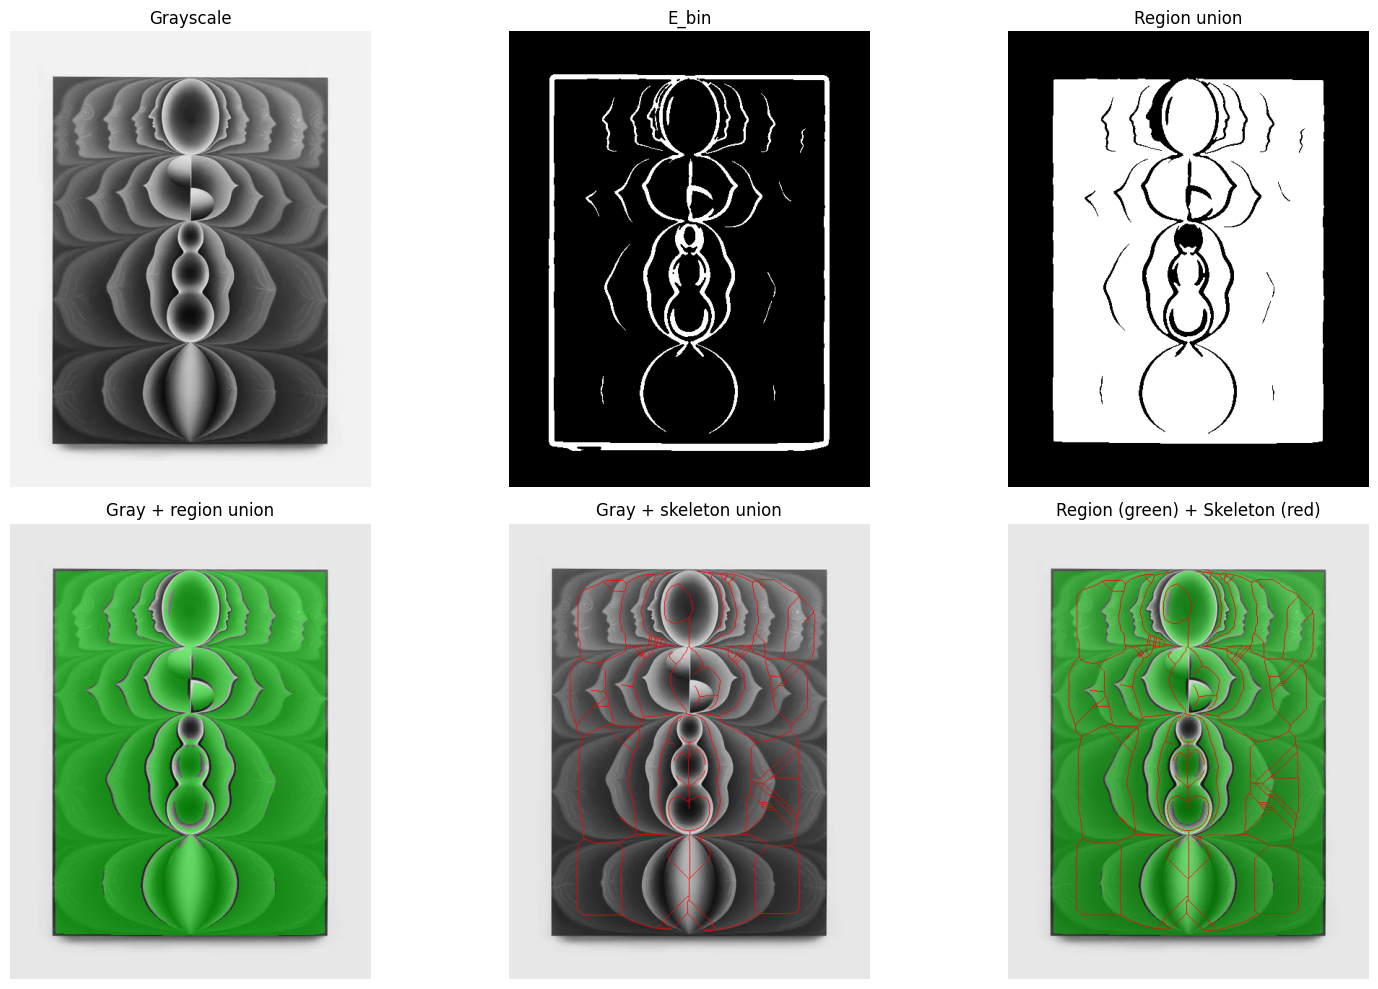

In [33]:
df_regions_top = pd.read_csv("outputs/step2/index_regions_topk_skel.csv")
qc_overlay_for_image("Expanding_Figure.webp", df0, df1, df_regions_top, Path("outputs/step3"))

Image: Prenatal_Plumb_Line.webp | split: real | regions: 3
Region union coverage:   3.45%
Edge density:            10.98%
Skeleton density:        0.12%
Skeleton inside region:  100.00%


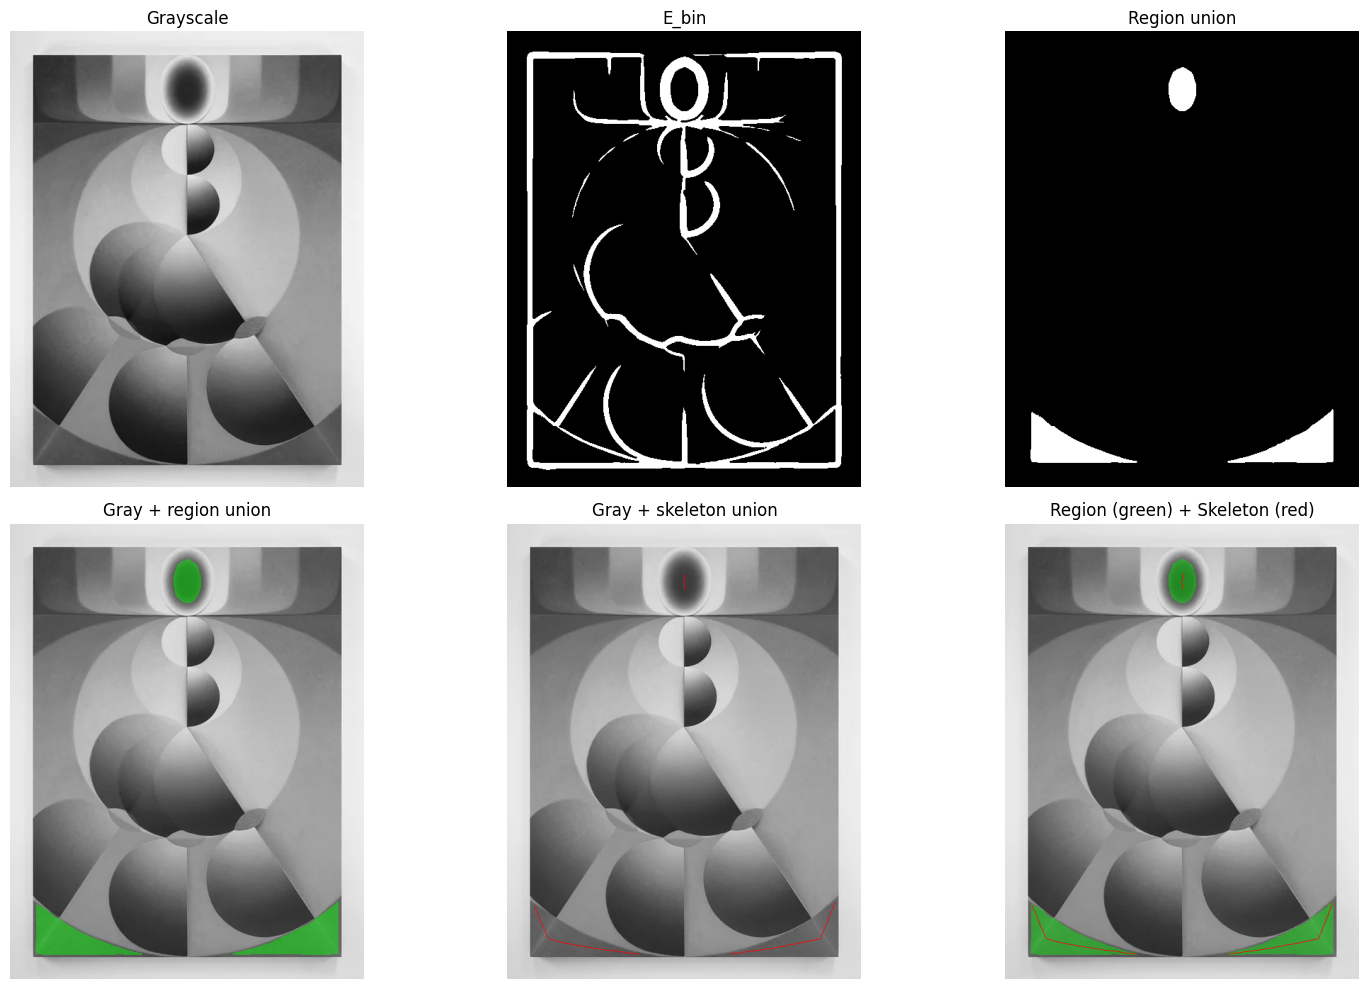

In [34]:
df_regions_top = pd.read_csv("outputs/step2/index_regions_topk_skel.csv")
qc_overlay_for_image("Prenatal_Plumb_Line.webp", df0, df1, df_regions_top, Path("outputs/step3"))

### PCA axis for a binary region mask

In [35]:
def pca_axis_from_mask(mask01: np.ndarray, sample_max: int = 50000, eps: float = 1e-9):
    """
    PCA on region pixels.
    Returns: (cx, cy, theta_rad, eig_ratio, eigvals[2], eigvecs[2x2])
    theta is angle of principal eigenvector in image coords (x right, y down).
    """
    ys, xs = np.where(mask01 > 0)
    n = len(xs)
    if n < 10:
        return None

    # optional subsample for speed
    if n > sample_max:
        idx = np.random.choice(n, size=sample_max, replace=False)
        xs = xs[idx]; ys = ys[idx]

    X = np.stack([xs.astype(np.float32), ys.astype(np.float32)], axis=1)  # (N,2) in (x,y)
    mean = X.mean(axis=0)
    Xc = X - mean

    # covariance
    C = (Xc.T @ Xc) / float(len(Xc))
    eigvals, eigvecs = np.linalg.eigh(C)   # ascending
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]           # columns are eigenvectors

    v = eigvecs[:, 0]  # principal direction
    theta = float(np.arctan2(v[1], v[0]))  # atan2(dy, dx)

    eig_ratio = float(eigvals[0] / (eigvals[1] + eps))
    cx, cy = float(mean[0]), float(mean[1])
    return cx, cy, theta, eig_ratio, eigvals, eigvecs

### Local Axes from Existing branch list

#### Using branches_df to Compute per-branch orientation + score

In [36]:
def pca_axis_from_polyline(pixels_yx, eps: float = 1e-9):
    """
    PCA on a polyline (list of (y,x) pixels).
    Returns theta_rad and eig_ratio for that branch.
    """
    if len(pixels_yx) < 5:
        return None, None
    ys = np.array([p[0] for p in pixels_yx], dtype=np.float32)
    xs = np.array([p[1] for p in pixels_yx], dtype=np.float32)
    X = np.stack([xs, ys], axis=1)  # (x,y)
    mean = X.mean(axis=0)
    Xc = X - mean
    C = (Xc.T @ Xc) / float(len(Xc))
    eigvals, eigvecs = np.linalg.eigh(C)
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]
    v = eigvecs[:, 0]
    theta = float(np.arctan2(v[1], v[0]))
    ratio = float(eigvals[0] / (eigvals[1] + eps))
    return theta, ratio

def downsample_polyline(pixels_yx, step: int = 3):
    if step <= 1:
        return pixels_yx
    return pixels_yx[::step]

### Outputs

In [37]:
def step4_compute_axes_for_regions(
    df_regions_in: pd.DataFrame,
    df0: pd.DataFrame,
    OUT3: Path,
    out_dir: Path,
    k_axes: int = 6,
    poly_step: int = 4,
):
    out_dir.mkdir(parents=True, exist_ok=True)

    pca_rows = []
    local_rows = []

    for _, r in df_regions_in.iterrows():
        split = r["split"]
        filename = r["filename"]
        stem = r["image_stem"]
        rid = int(r["region_id"])

        # --- load region mask ---
        m = cv2.imread(r["region_path"], cv2.IMREAD_GRAYSCALE)
        if m is None:
            continue
        mask01 = (m > 0).astype(np.uint8)

        # --- PCA axis on region pixels ---
        pca = pca_axis_from_mask(mask01)
        if pca is None:
            continue
        cx, cy, theta, eig_ratio, eigvals, _ = pca

        pca_rows.append({
            "split": split, "filename": filename, "image_stem": stem, "region_id": rid,
            "centroid_x": cx, "centroid_y": cy,
            "theta_rad": theta, "theta_deg": float(np.degrees(theta)),
            "eig1": float(eigvals[0]), "eig2": float(eigvals[1]),
            "eig_ratio": eig_ratio,
            "area_px": int(r["area_px"]), "area_frac": float(r["area_frac"]),
        })

        # --- local symmetry axes from skeleton branches ---
        skel_path = OUT3 / "skeletons" / split / stem / f"region_{rid:03d}_skel.png"
        sk = cv2.imread(str(skel_path), cv2.IMREAD_GRAYSCALE)
        if sk is None:
            continue
        skel01 = (sk > 0).astype(np.uint8)

        # radius map from mask (width proxy along skeleton)
        radius = distance_transform_radius(mask01)

        # trace branches -> polylines
        nodes, branches = trace_branches(skel01)

        # compute branch score + orientation
        cand = []
        for bid, b in enumerate(branches):
            met = branch_metrics(b, radius)
            if met["length_px"] <= 0:
                continue

            # branch orientation via PCA on its points
            theta_b, ratio_b = pca_axis_from_polyline(b["pixels"])
            if theta_b is None:
                continue

            score = float(met["length_px"] * (met["mean_radius_px"] + 1e-6))  # prominence
            cand.append((score, bid, met, theta_b, ratio_b, b["pixels"]))

        # keep top-k prominent axes
        cand.sort(key=lambda t: t[0], reverse=True)
        cand = cand[:k_axes]

        for rank, (score, bid, met, theta_b, ratio_b, pix) in enumerate(cand, start=1):
            poly = downsample_polyline(pix, step=poly_step)
            # store compact as string "y,x;y,x;..."
            poly_str = ";".join([f"{int(y)},{int(x)}" for (y, x) in poly])

            local_rows.append({
                "split": split, "filename": filename, "image_stem": stem, "region_id": rid,
                "axis_rank": rank,
                "branch_id": int(bid),
                "score": float(score),
                "theta_rad": float(theta_b),
                "theta_deg": float(np.degrees(theta_b)),
                "eig_ratio": float(ratio_b),
                "length_px": float(met["length_px"]),
                "mean_radius_px": float(met["mean_radius_px"]),
                "max_radius_px": float(met["max_radius_px"]),
                "polyline_yx": poly_str,
                "skel_path": str(skel_path.as_posix()),
            })

    df_pca = pd.DataFrame(pca_rows)
    df_local = pd.DataFrame(local_rows)

    pca_csv = out_dir / "index_region_axes_pca.csv"
    local_csv = out_dir / "index_local_symmetry_axes.csv"
    df_pca.to_csv(pca_csv, index=False)
    df_local.to_csv(local_csv, index=False)

    print("Saved:", pca_csv, "| rows:", len(df_pca))
    print("Saved:", local_csv, "| rows:", len(df_local))
    return df_pca, df_local

In [38]:
OUT4 = Path("outputs/step4")
df_regions_top = pd.read_csv("outputs/step2/index_regions_topk_skel.csv")  # or whichever you trust

df_pca, df_local = step4_compute_axes_for_regions(
    df_regions_in=df_regions_top,
    df0=df0,
    OUT3=Path("outputs/step3"),
    out_dir=OUT4,
    k_axes=6,
    poly_step=4,
)

Saved: outputs\step4\index_region_axes_pca.csv | rows: 214
Saved: outputs\step4\index_local_symmetry_axes.csv | rows: 657


### Visual Check

In [39]:
def draw_step4_axes(filename, df0, df_regions_in, df_pca, df_local, OUT3: Path, max_local=6):
    row0 = df0[df0["filename"] == filename].iloc[0]
    gray = cv2.imread(row0["gray_path"], cv2.IMREAD_GRAYSCALE)
    split = row0["split"]
    stem = Path(filename).stem

    AXIS_STRENGTH_MIN = 1.35  # tune 1.2–1.6

    regs = df_regions_in[(df_regions_in["filename"] == filename) & (df_regions_in["split"] == split)]
    if len(regs) == 0:
        print("No regions for this image in df_regions_in")
        return

    H, W = gray.shape
    canvas = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB).astype(np.float32)

    # region union overlay
    union = np.zeros((H, W), np.uint8)
    for _, r in regs.iterrows():
        m = cv2.imread(r["region_path"], cv2.IMREAD_GRAYSCALE)
        if m is not None:
            union |= (m > 0).astype(np.uint8)
    canvas[union > 0] = 0.65 * canvas[union > 0] + 0.35 * np.array([0, 255, 0], np.float32)

    # draw PCA axis per region
    for _, r in regs.iterrows():
        rid = int(r["region_id"])
        p = df_pca[(df_pca["filename"] == filename) & (df_pca["split"] == split) & (df_pca["region_id"] == rid)]
        if len(p) == 0:
            continue
        p = p.iloc[0]
        cx, cy = float(p["centroid_x"]), float(p["centroid_y"])
        theta = float(p["theta_rad"])
        L = 0.35 * max(H, W)  # visual length
        x1 = int(cx - L * np.cos(theta)); y1 = int(cy - L * np.sin(theta))
        x2 = int(cx + L * np.cos(theta)); y2 = int(cy + L * np.sin(theta))
        cv2.line(canvas, (x1, y1), (x2, y2), (0, 255, 255), 2)  # cyan

    # draw local axes polylines
    loc = df_local[(df_local["filename"] == filename) & (df_local["split"] == split)]
    loc = loc.sort_values(["region_id", "axis_rank"]).head(max_local)

    for _, a in loc.iterrows():
        poly = a["polyline_yx"]
        pts = []
        for item in str(poly).split(";"):
            yx = item.split(",")
            if len(yx) != 2:
                continue
            y, x = int(yx[0]), int(yx[1])
            pts.append((x, y))
        for p1, p2 in zip(pts[:-1], pts[1:]):
            cv2.line(canvas, p1, p2, (255, 200, 0), 2)

    plt.figure(figsize=(7, 9))
    plt.imshow(canvas.astype(np.uint8))
    plt.title(f"Step 4 axes: {filename}")
    plt.axis("off")
    plt.show()

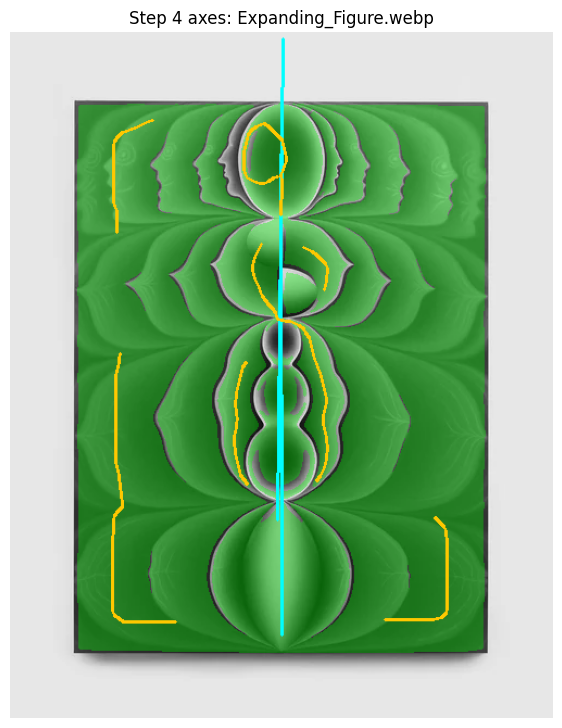

In [40]:
draw_step4_axes(
    filename="Expanding_Figure.webp",
    df0=df0,
    df_regions_in=df_regions_top,
    df_pca=df_pca,
    df_local=df_local,
    OUT3=Path("outputs/step3"),
    max_local=10
)

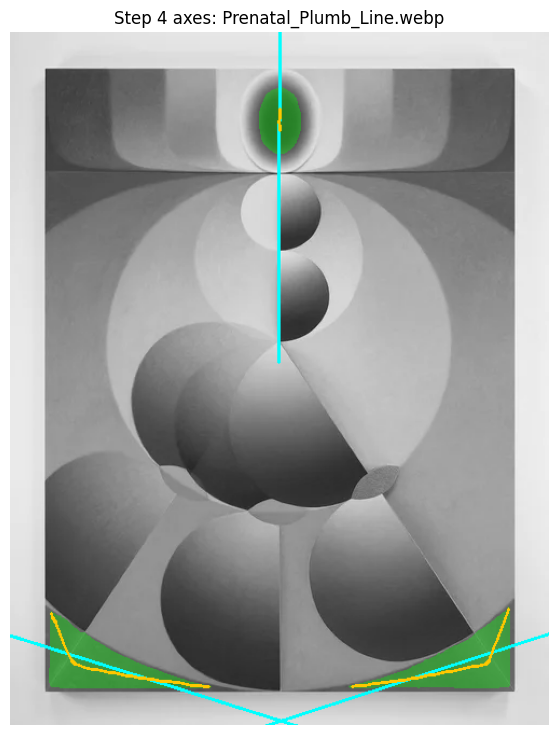

In [41]:
draw_step4_axes(
    filename="Prenatal_Plumb_Line.webp",
    df0=df0,
    df_regions_in=df_regions_top,
    df_pca=df_pca,
    df_local=df_local,
    OUT3=Path("outputs/step3"),
    max_local=10
)

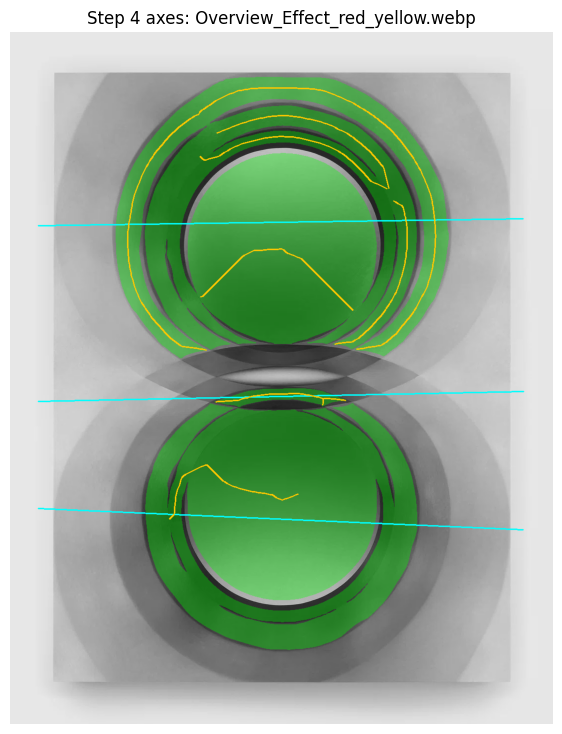

In [42]:
draw_step4_axes(
    filename="Overview_Effect_red_yellow.webp",
    df0=df0,
    df_regions_in=df_regions_top,
    df_pca=df_pca,
    df_local=df_local,
    OUT3=Path("outputs/step3"),
    max_local=10
)

In [43]:
def pca_axis_from_mask(mask01: np.ndarray, mode="boundary", eps=1e-9):
    """
    mode:
      - "region"   : all foreground pixels
      - "boundary" : 1px boundary of mask
      - "skeleton" : skeleton pixels weighted by radius (needs distanceTransform)
    returns dict with center, angle_rad, axis_strength, eigvals
    """
    m = (mask01 > 0).astype(np.uint8)
    H, W = m.shape

    if mode == "boundary":
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        er = cv2.erode(m, k, iterations=1)
        pts = np.column_stack(np.where((m > 0) & (er == 0)))  # (y,x)
        wts = None

    elif mode == "region":
        pts = np.column_stack(np.where(m > 0))
        wts = None

    elif mode == "skeleton":
        # requires skeletonize_mask from your code
        sk = skeletonize_mask(m)
        pts = np.column_stack(np.where(sk > 0))
        if pts.shape[0] == 0:
            return None
        dist = cv2.distanceTransform((m*255).astype(np.uint8), cv2.DIST_L2, 3)
        wts = dist[pts[:,0], pts[:,1]]  # radius weights

    else:
        raise ValueError("mode must be 'region', 'boundary', or 'skeleton'")

    if pts.shape[0] < 10:
        return None

    Y = pts[:,0].astype(np.float64)
    X = pts[:,1].astype(np.float64)

    if wts is None:
        wts = np.ones_like(X)

    wts = wts.astype(np.float64)
    wsum = wts.sum() + eps

    cx = (wts * X).sum() / wsum
    cy = (wts * Y).sum() / wsum

    Xc = X - cx
    Yc = Y - cy

    # weighted covariance
    Cxx = (wts * Xc * Xc).sum() / wsum
    Cyy = (wts * Yc * Yc).sum() / wsum
    Cxy = (wts * Xc * Yc).sum() / wsum

    cov = np.array([[Cxx, Cxy],
                    [Cxy, Cyy]], dtype=np.float64)

    eigvals, eigvecs = np.linalg.eigh(cov)  # ascending
    l2, l1 = eigvals[0], eigvals[1]
    v1 = eigvecs[:,1]  # principal eigenvector

    angle = float(np.arctan2(v1[1], v1[0]))  # in (x,y) space
    axis_strength = float(l1 / (l2 + eps))

    return {
        "cx": float(cx), "cy": float(cy),
        "angle": angle,
        "axis_strength": axis_strength,
        "eig1": float(l1), "eig2": float(l2),
        "n_pts": int(len(pts))
    }

In [45]:
import numpy as np
import pandas as pd

# --- Load if not already loaded ---
# df0 = pd.read_csv("outputs/step0/index_step0.csv")
# df_regions = pd.read_csv("outputs/step2/index_regions.csv")
# nodes_df = pd.read_csv("outputs/step3/index_skeleton_nodes.csv")
# branches_df = pd.read_csv("outputs/step3/index_skeleton_branches.csv")

# If you're using df_regions_full with skel_len_norm etc, you can use that instead:
df_regions = df_regions.copy()

# -------------------------
# Helper aggregations
# -------------------------

# (A) Regions per image
reg_counts = (df_regions.groupby(["split","filename"])
                      .size()
                      .reset_index(name="n_regions"))

# (B) Skeleton length per region (sum of branch lengths)
skel_len = (branches_df.groupby(["split","filename","region_id"])["length_px"]
                    .sum()
                    .reset_index(name="skel_length_px"))

# (C) Junction count per region
junctions = (nodes_df[nodes_df["type"]=="junction"]
             .groupby(["split","filename","region_id"])
             .size()
             .reset_index(name="n_junctions"))

# (D) Total nodes and branches per region
node_counts = (nodes_df.groupby(["split","filename","region_id"])
               .size()
               .reset_index(name="n_nodes"))

branch_counts = (branches_df.groupby(["split","filename","region_id"])
                 .size()
                 .reset_index(name="n_branches"))

# Merge region table with skeleton stats
R = (df_regions.merge(skel_len, on=["split","filename","region_id"], how="left")
              .merge(junctions, on=["split","filename","region_id"], how="left")
              .merge(node_counts, on=["split","filename","region_id"], how="left")
              .merge(branch_counts, on=["split","filename","region_id"], how="left"))

def coalesce_cols(df, base):
    if base in df.columns:
        return df
    x = f"{base}_x"
    y = f"{base}_y"
    if x in df.columns and y in df.columns:
        df[base] = df[x].combine_first(df[y])
        df.drop(columns=[x, y], inplace=True)
    elif x in df.columns:
        df.rename(columns={x: base}, inplace=True)
    elif y in df.columns:
        df.rename(columns={y: base}, inplace=True)
    return df

R = coalesce_cols(R, "skel_length_px")
R = coalesce_cols(R, "n_junctions")
R = coalesce_cols(R, "n_nodes")
R = coalesce_cols(R, "n_branches")

R["skel_length_px"] = R["skel_length_px"].fillna(0.0)
R["n_junctions"]    = R["n_junctions"].fillna(0).astype(int)
R["n_nodes"]        = R["n_nodes"].fillna(0).astype(int)
R["n_branches"]     = R["n_branches"].fillna(0).astype(int)

# Normalize skeleton length by image diagonal so images of different sizes compare fairly
diag = np.sqrt(R["H"]**2 + R["W"]**2) + 1e-9
R["skel_len_norm"] = R["skel_length_px"] / diag

# "Branchiness": junction density and branches per unit length
R["junctions_per_1kpx"] = R["n_junctions"] / (R["skel_length_px"]/1000.0 + 1e-9)
R["branches_per_1kpx"]  = R["n_branches"]  / (R["skel_length_px"]/1000.0 + 1e-9)

# -------------------------
# Define QC flags (tweakable thresholds)
# -------------------------
# 1) No meaningful candidates: 0–1 regions total for the image
FLAG_MAX_REGIONS_FOR_FAIL = 1

# 2) Skeleton mostly empty on large region:
#    "large" = region covers >= X% of image; "empty" = normalized skeleton length below Y
LARGE_AREA_FRAC = 0.08          # 8% of image area is "large" (tweak)
EMPTY_SKEL_NORM = 0.002         # 0.2% of diagonal in skeleton length (tweak)

# 3) Exploding skeleton graphs:
#    high junction density OR high branches density
EXPLODE_JUNC_PER_1KPX = 20      # tweak
EXPLODE_BR_PER_1KPX   = 35      # tweak

# -------------------------
# Per-image QC summary
# -------------------------

# Candidate failure flag
img_qc = reg_counts.copy()
img_qc["flag_low_candidates"] = img_qc["n_regions"] <= FLAG_MAX_REGIONS_FOR_FAIL

# Empty-skeleton-on-large-region flag per region, then reduced to per-image
R["flag_large_empty_skel"] = (R["area_frac"] >= LARGE_AREA_FRAC) & (R["skel_len_norm"] <= EMPTY_SKEL_NORM)
empty_by_img = (R.groupby(["split","filename"])["flag_large_empty_skel"]
                .any()
                .reset_index(name="flag_large_empty_skel"))

# Exploding flag per region, then per-image
R["flag_exploding"] = (R["junctions_per_1kpx"] >= EXPLODE_JUNC_PER_1KPX) | (R["branches_per_1kpx"] >= EXPLODE_BR_PER_1KPX)
expl_by_img = (R.groupby(["split","filename"])["flag_exploding"]
               .any()
               .reset_index(name="flag_exploding"))

# Merge image-level flags
img_qc = (img_qc.merge(empty_by_img, on=["split","filename"], how="left")
               .merge(expl_by_img, on=["split","filename"], how="left"))

img_qc["flag_large_empty_skel"] = img_qc["flag_large_empty_skel"].fillna(False)
img_qc["flag_exploding"]        = img_qc["flag_exploding"].fillna(False)

# Overall "bad image" if any failure mode
img_qc["flag_any_problem"] = img_qc[["flag_low_candidates","flag_large_empty_skel","flag_exploding"]].any(axis=1)

# -------------------------
# Print dataset-level rates
# -------------------------
N = len(img_qc)
print("=== DATASET QC SUMMARY ===")
print(f"Images total: {N}")
print(f"Low candidates (<= {FLAG_MAX_REGIONS_FOR_FAIL}): {img_qc['flag_low_candidates'].mean()*100:.1f}%")
print(f"Large region + empty skeleton: {img_qc['flag_large_empty_skel'].mean()*100:.1f}%")
print(f"Exploding skeleton graphs: {img_qc['flag_exploding'].mean()*100:.1f}%")
print(f"Any problem: {img_qc['flag_any_problem'].mean()*100:.1f}%")

# Show worst offenders
print("\n=== SAMPLE PROBLEM IMAGES ===")
display(img_qc[img_qc["flag_any_problem"]].sort_values(["flag_low_candidates","flag_large_empty_skel","flag_exploding"], ascending=False).head(20))

# Optional: inspect top exploding regions
print("\n=== TOP EXPLODING REGIONS (by junction density) ===")
display(R.sort_values("junctions_per_1kpx", ascending=False)[
    ["split","filename","region_id","area_frac","skel_length_px","skel_len_norm","n_junctions","n_branches","junctions_per_1kpx","branches_per_1kpx","boundary_evidence","leakiness"]
].head(25))


=== DATASET QC SUMMARY ===
Images total: 107
Low candidates (<= 1): 36.4%
Large region + empty skeleton: 23.4%
Exploding skeleton graphs: 43.9%
Any problem: 78.5%

=== SAMPLE PROBLEM IMAGES ===


,split,filename,n_regions,flag_low_candidates,flag_large_empty_skel,flag_exploding,flag_any_problem
11,generated,ComfyUI_00094_.png,1,True,True,False,True
45,generated,ComfyUI_00144_.png,1,True,True,False,True
67,real,Book_of_Birth_2.webp,1,True,True,False,True
68,real,Colostrum_well.webp,1,True,True,False,True
78,real,Green_Brain.webp,1,True,True,False,True
84,real,Meeting_Place.webp,1,True,True,False,True
92,real,Overview_Effect.webp,1,True,True,False,True
100,real,Pregnancy_in_three_acts.webp,1,True,True,False,True
105,real,around_the_clock_alizarin.webp,1,True,True,False,True
10,generated,ComfyUI_00093_.png,1,True,False,True,True



=== TOP EXPLODING REGIONS (by junction density) ===


,split,filename,region_id,area_frac,skel_length_px,skel_len_norm,n_junctions,n_branches,junctions_per_1kpx,branches_per_1kpx,boundary_evidence,leakiness
44,generated,ComfyUI_00104_.png,2,0.270924,0.000000,0.000000,1,0,1.000000e+09,0.000000,0.445890,0.0
119,generated,ComfyUI_00160_.png,1,0.020393,0.000000,0.000000,1,0,1.000000e+09,0.000000,0.443574,0.0
46,generated,ComfyUI_00105_.png,1,0.179329,2240.902812,3.094839,367,611,1.637733e+02,272.657965,0.450705,0.0
188,real,Perspective_From_Above_and_Below.webp,1,0.006084,434.445743,0.461186,71,121,1.634266e+02,278.515791,0.566722,0.0
128,real,Birth_perspective_from_above_and_below.webp,2,0.007489,513.043723,0.544272,67,133,1.305932e+02,259.237164,0.543692,0.0
11,generated,ComfyUI_00087_.png,2,0.194763,4344.067602,5.999452,547,896,1.259189e+02,206.258300,0.547613,0.0
55,generated,ComfyUI_00110_.png,1,0.094891,2132.838887,2.945595,237,395,1.111195e+02,185.199174,0.164323,0.0
32,generated,ComfyUI_00099_.png,1,0.154236,2974.403605,4.107853,281,460,9.447272e+01,154.652852,0.313379,0.0
69,generated,ComfyUI_00126_.png,2,0.007198,203.823376,0.281494,18,31,8.831175e+01,152.092465,0.175445,0.0
92,generated,ComfyUI_00145_.png,2,0.025852,571.256926,0.788945,49,76,8.577577e+01,133.039962,0.364840,0.0
